# Segmentation Modules for SPEX Pipeline

### Functions for image preproessing, segmentation, and feature extraction

In [20]:
import os
import glob
import numpy as np
from skimage import segmentation
from tifffile import TiffWriter, TiffFile

import spex_segment as sp

In [2]:
os.chdir('/gne/data/pathology/t3imagedata/Projects/H2020-428/Images/PAC0002_KerenMIBI/Converted')
img='TA459_multipleCores2_Run-4_Point1.tiff'

### Step 1: Load image and extract channels as a list
##### (or use OMERO api to pull tiff image and channel names)

In [3]:
Image, channel=sp.load_tiff(img,is_mibi=True)

print("Image loaded with the following",len(channel),"channels:",channel)

Image loaded with the following 44 channels: ['Au', 'Background', 'Beta catenin', 'Ca', 'CD11b', 'CD11c', 'CD138', 'CD16', 'CD20', 'CD209', 'CD3', 'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD63', 'CD68', 'CD8', 'dsDNA', 'EGFR', 'Fe', 'FoxP3', 'H3K27me3', 'H3K9ac', 'HLA-DR', 'HLA_Class_1', 'IDO', 'Keratin17', 'Keratin6', 'Ki67', 'Lag3', 'MPO', 'Na', 'P', 'p53', 'Pan-Keratin', 'PD-L1', 'PD1', 'phospho-S6', 'Si', 'SMA', 'Ta', 'Vimentin']


### Step 2: Image preprocessing
##### These modules are optional. User will select what functions they want to chain together

##### OPTIONAL - Subtract Background noise

In [ ]:
index=channel.index('Au')
bgcorrect_Image=sp.background_subtract(Image, index, 10,2)

index=channel.index('Background')
bgcorrect_Image=sp.background_subtract(bgcorrect_Image, index, 10,2)

##### OPTIONAL - NLM Denoising

In [ ]:
nlm_Image=sp.nlm_denoise(bgcorrect_Image,5,6)

##### OPTIONAL - Median filter

In [4]:
list=['dsDNA','H3K9ac','H3K27me3']

to_denoise=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_denoise.append(index)
to_denoise.sort()

median_Image=sp.median_denoise(Image,4,to_denoise)

### Step 3: Cell Segmentation
##### User will select 1 of the 3 segmentation options. Output will be a label image where each cell is assigned an integer value.

##### StarDist deep learning segmentation

In [5]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

stardist_label=sp.stardist_cellseg(median_Image, to_merge, 1, 0.5, 1, 98.5)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


##### OR Cellpose deep learning segmentation

In [ ]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

cellpose_label=sp.cellpose_cellseg(median_Image, to_merge,12, 1)

##### OR DeepCell deep learning segmentation

In [ ]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

deepcell_label=sp.deepcell_segmentation(Image, to_merge, 0.39)

##### OR Classic watershed segmentation

In [ ]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

classic_label=sp.classicwatershed_cellseg(median_Image, to_merge)

### Step 3a: Visualization and saving of segmentation results

In [47]:
from tifffile import imwrite, imsave
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage.segmentation import expand_labels,mark_boundaries

2022-12-22 12:26:17,781 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


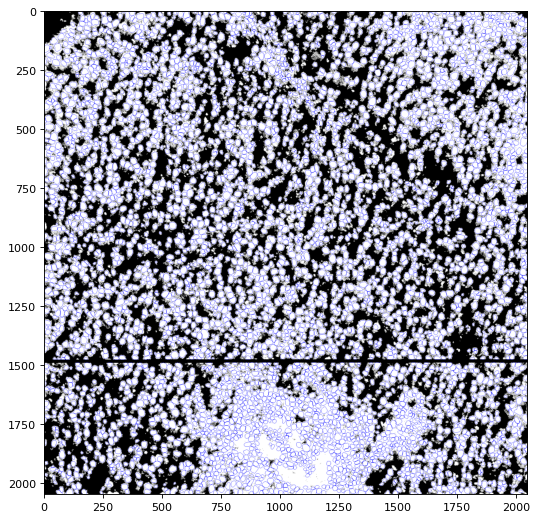

In [56]:
#save and show boundary of segmentation

nuc=np.zeros((Image.shape[1],Image.shape[2]))
for i in to_merge:
    temp=Image[i]
    nuc=temp+nuc

#save full resolution grayscale image of segmentation
imwrite(im.split('.')[0]+'_segmentationlabels.tif', stardist_label, photometric='minisblack') 

#save low res image
figure(figsize=(8, 8), dpi=80)
boundary=mark_boundaries(np.squeeze(nuc), stardist_label,(0, 0, 255)).astype('uint8')
plt.imsave(img.split('.')[0]+'_segmentation.jpg',boundary)

plt.imshow(mark_boundaries(np.squeeze(nuc), stardist_label,(0, 0, 255)))

### Step 4: Postprocessing
##### These modules are optional. User will select what functions they want to chain together

##### Rescue cells missed by DL model. (uses traditional watershed) - This is an optional step to add after segmentatio step.

In [ ]:
list=['dsDNA','H3K9ac','H3K27me3']

to_merge=[]      
for i in range(0,len(list),1):
    index=channel.index(list[i])
    to_merge.append(index)
to_merge.sort()

new_label=sp.rescue_cells(Image,to_merge, stardist_label)

##### Remove small and/or large segments

In [ ]:
newlabel=sp.remove_small_objects(new_label, 8)
newlabel=sp.remove_large_objects(new_label, 75)

##### Dilate nuclei boundaries to simulate a cell

In [6]:
expanded_label=sp.simulate_cell(stardist_label, 10)

### Step 4a: Visualization and saving is same as Step 3a

### Step 5: Feature Extraction

##### Extract features to be passed to the phenotyping modules

In [57]:
df=sp.feature_extraction(Image, expanded_label,channel)
df

,label,centroid-0,centroid-1,Au,Background,Beta catenin,Ca,CD11b,CD11c,CD138,...,P,p53,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin
0,1,195.573454,1960.447165,2.880155,0.131443,0.0,3.935567,0.000000,0.000000,0.466495,...,1.305412,0.0,0.806701,0.0,0.0,0.521907,0.452320,0.068299,1.157216,0.0
1,2,1714.545078,117.876684,0.595855,0.089119,0.0,1.675648,0.000000,0.000000,0.000000,...,0.559585,0.0,0.563731,0.0,0.0,0.218653,0.366839,0.000000,0.214508,0.0
2,3,1819.518559,716.461790,2.094978,0.061135,0.0,1.740175,0.000000,0.000000,0.216157,...,0.796943,0.0,0.203057,0.0,0.0,0.208515,0.394105,0.000000,1.163755,0.0
3,4,1005.256284,997.931944,1.989577,0.074188,0.0,2.496015,0.000000,0.000000,0.000000,...,0.917229,0.0,0.182097,0.0,0.0,0.147149,0.442060,0.000000,0.870632,0.0
4,5,741.481994,1340.619114,5.551247,0.096953,0.0,4.918283,0.000000,0.000000,0.004155,...,1.926593,0.0,0.105263,0.0,0.0,0.644044,0.445983,0.630194,3.072022,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106,5107,276.051587,798.587302,8.371032,0.079365,0.0,1.726190,0.031746,0.158730,0.000000,...,0.400794,0.0,0.099206,0.0,0.0,0.924603,0.398810,0.000000,4.888889,0.0
5107,5108,801.557214,1346.694030,1.582090,0.044776,0.0,1.905473,0.000000,0.248756,0.000000,...,0.577114,0.0,0.002488,0.0,0.0,0.365672,6.763682,0.017413,0.335821,0.0
5108,5109,864.042042,124.561562,22.255255,0.066066,0.0,2.135135,0.000000,0.000000,0.000000,...,0.693694,0.0,0.177177,0.0,0.0,0.204204,0.372372,0.000000,13.372372,0.0
5109,5110,2034.231454,1265.569733,0.373887,0.062315,0.0,2.005935,0.000000,0.000000,0.000000,...,2.041543,0.0,0.000000,0.0,0.0,0.320475,0.317507,0.000000,0.097923,0.0


### Step 5a: Visualization of features

In [8]:
import seaborn as sns

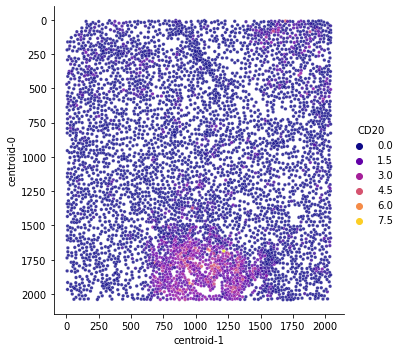

In [22]:
df_select=df               #user will select the image dataframe
channel_selection='CD20'   #user will select the channel

g=sns.relplot(x='centroid-1', y='centroid-0', hue=channel_selection, alpha=.8,s=12, palette='plasma',data=df_select)
for ax in g.axes[0]:
    ax.invert_yaxis()

### Step 5b: Package and save the analysis data

In [124]:
import anndata as ad
from anndata import AnnData
import scanpy as sc
from scipy.stats import zscore

In [125]:
# format coordinates
coordinates=[]
for k in range(0,len(df),1):
    coordinates.append([df.loc[df.index[k],'centroid-1'],df.loc[df.index[k],'centroid-0']])

coordinates=np.array(coordinates) 
coordinates

# format labels.
celltype=df[['label']]
celltype['label'] = celltype.label.astype('category')
celltype = celltype.rename(columns={'label': 'Cell_ID'})

# expression data
expression_data=df[channel]

# package in anndata object
adata = AnnData(expression_data, obsm={"spatial": coordinates})
adata.obs['Cell_ID'] = [str(i) for i in celltype['Cell_ID'].tolist()]
adata.layers["zscored"] = expression_data.apply(zscore)

adata.write(img.split('.')[0]+'.h5ad', compression="gzip") # save data to disk as anndata object

adata

<ipython-input-125-6dbe3325f03b> (11): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
anndata.py (120): Transforming to str index.


AnnData object with n_obs × n_vars = 5111 × 44
    obs: 'Cell_ID'
    obsm: 'spatial'
    layers: 'zscored'

### Similar process for phenotyping/clustering results

In [126]:
df['cluster_id'] = np.random.randint(1, 6, df.shape[0]) # create random example cluster ids

# format cluster ids into anndata
cluster=df[['cluster_id']]
cluster['cluster_id'] = cluster.cluster_id.astype('category')

#adata.obs['cluster_id'] = cluster['cluster_id'].tolist()  #add cluster to adata object
adata.obs['cluster_id'] = [str(i) for i in cluster['cluster_id'].tolist()]

adata.write(img.split('.')[0]+'.h5ad', compression="gzip") # save data to disk as anndata object

adata

<ipython-input-126-26798401b826> (5): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
anndata.py (1220): The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'cluster_id' as categorical


AnnData object with n_obs × n_vars = 5111 × 44
    obs: 'Cell_ID', 'cluster_id'
    obsm: 'spatial'
    layers: 'zscored'

### Phenotyping plotting

In [127]:
import scanpy as sc

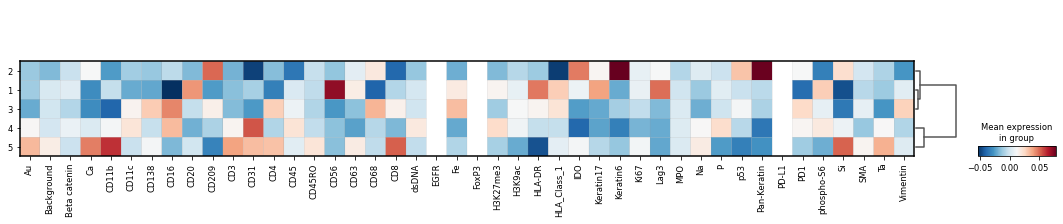

In [128]:
var_names=adata.to_df().columns.tolist()
sc.pl.matrixplot(adata, var_names, 'cluster_id', dendrogram=True, cmap='RdBu_r',layer='zscored')

[<Axes:ylabel='CD20'>, <Axes:ylabel='CD3'>, <Axes:ylabel='CD4'>]

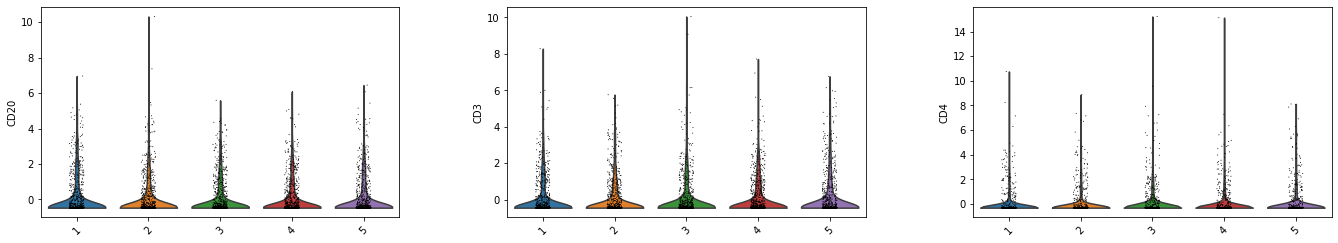

In [129]:
markerlist=['CD20','CD3','CD4'] #user selection

sc.pl.violin(adata, markerlist, groupby='cluster_id', rotation=45, show=False,layer='zscored')

## Example Batch Process
##### Running a folder of images through the SPEX pipeline

In [ ]:
os.chdir('/gne/data/pathology/t3imagedata/Projects/H2020-428/Images/PAC0002_KerenMIBI/Converted')
files = glob.glob('*.tiff', recursive = False)
files

In [ ]:
for image in files:
    #Load Image
    Image, channel=sp.load_tiff(image,is_mibi=True)

    #Denoise Image
    list=['dsDNA','H3K9ac','H3K27me3']

    to_denoise=[]      
    for i in range(0,len(list),1):
        index=channel.index(list[i])
        to_denoise.append(index)
    to_denoise.sort()

    median_Image=sp.median_denoise(Image,5,to_denoise)

    #Run Segmentation
    list=['dsDNA','H3K9ac','H3K27me3']

    to_merge=[]      
    for i in range(0,len(list),1):
        index=channel.index(list[i])
        to_merge.append(index)
    to_merge.sort()
    
    stardist_label=sp.stardist_cellseg(median_Image, to_merge, 1, 0.5, 1, 98.5)
    #cellpose_label=sp.cellpose_cellseg(median_Image, index,12, 1)
    deepcell_label=sp.deepcell_segmentation(Image, to_merge, 0.39)

    #index=channel.index('H3K27me3')
    new_label=sp.rescue_cells(Image,to_merge, stardist_label)
    #new_label2=sp.rescue_cells(Image,index, cellpose_label)
    #new_label3=sp.rescue_cells(Image,index, deepcell_label)

    #Dilate Cells
    expanded_label=sp.simulate_cell(new_label, 10)
    #expanded_label2=sp.simulate_cell(new_label2, 10)
    expanded_label3=sp.simulate_cell(deepcell_label, 8)

    #Extract Features
    df=sp.feature_extraction(Image, expanded_label,channel)
    df2=sp.feature_extraction(Image, expanded_label3,channel)

    #Save Feature Data
    csvname = image.split(".tiff")[0]+'_stardist.csv'
    df.to_csv(csvname, index = False)
    csvname = image.split(".tiff")[0]+'_deepcell.csv'
    df2.to_csv(csvname, index = False)

    #Save Image of segmentation
    imagename = image.split(".tiff")[0]+'_label.ome.tiff'

    contour=segmentation.find_boundaries(expanded_label, connectivity=1, mode='thick', background=0)
    #contour2=segmentation.find_boundaries(expanded_label2, connectivity=1, mode='thick', background=0)
    contour3=segmentation.find_boundaries(expanded_label3, connectivity=1, mode='thick', background=0)
    pseudoIF=np.stack((Image[channel.index('dsDNA')],Image[channel.index('H3K9ac')],Image[channel.index('H3K27me3')],contour,contour3), axis=0)

    with TiffWriter(imagename, bigtiff=True) as tif:
        options = dict(tile=(512, 512),photometric='minisblack')
        tif.write(pseudoIF, **options, metadata={'PhysicalSizeX':0.39,'PhysicalSizeY':0.39,'Channel': {'Name': ["dsDNA","H3K9ac","H3K27me3", "Stardist","DeepCell"]}})